# Simulations for Zhang et al., 2021
Christoph Schmidt-Hieber, Institut Pasteur, 2021

In [1]:
import matplotlib
%matplotlib nbagg
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA
from matplotlib.patches import ConnectionPatch as CP
import seaborn as sns

In [2]:
import sys
import numpy as np

In [3]:
def run_sim(weights, inhibit=[], tbase=15, trun=25, tstop=30, dt=0.0005, ext_base=0.0, ext_ramp=0.5, ext_run=1.0):
    t = np.arange(0, tstop, dt)

    tau_pyrs = 0.04
    tau_soms = 0.02 #0.02 # manuscript: 0.02
    tau_parv = 0.01 # manuscript: 0.01

    ext = np.zeros(t.shape)
    ext[t<tbase] = ext_base # manuscript: 0.1
    ext[(t>=tbase) & (t<trun)] = ext_ramp
    ext[t>=trun] = ext_run # manuscript: 0.6

    soms = np.zeros(t.shape).astype(float) + 0.0
    pyrs = np.zeros(t.shape).astype(float) + 0.0
    parv = np.zeros(t.shape).astype(float) + 0.0

    noises = np.random.normal(0, 0, (3, t.shape[0]))
    ext += np.random.normal(0, 0, t.shape[0])
    ext[ext < 0] = 0

    for ndt,ts in enumerate(t):

        if ndt > 0:
            # sys.stdout.write('.')
            # sys.stdout.flush()
            out_soms = soms[ndt-1] * ((soms[ndt-1] > 0) * 1.0)
            out_parv = parv[ndt-1] * ((parv[ndt-1] > 0) * 1.0)
            out_pyrs = pyrs[ndt-1] * ((pyrs[ndt-1] > 0) * 1.0)

            dpyrs = \
                weights['w_ext_pyrs'] * ext[ndt] + \
                weights['w_soms_pyrs'] * out_soms + \
                weights['w_pyrs_pyrs'] * out_pyrs + \
                weights['w_parv_pyrs'] * out_parv + \
                noises[0][ndt]
            dsoms = \
                weights['w_ext_soms'] * ext[ndt] + \
                weights['w_soms_soms'] * out_soms + \
                weights['w_pyrs_soms'] * out_pyrs + \
                weights['w_parv_soms'] * out_parv + \
                noises[1][ndt]
            dparv = \
                weights['w_ext_parv'] * ext[ndt] + \
                weights['w_soms_parv'] * out_soms + \
                weights['w_pyrs_parv'] * out_pyrs + \
                weights['w_parv_parv'] * out_parv + \
                noises[2][ndt]
            if 'pyrs' in inhibit:
                pyrs[ndt] = 0
            else:
                pyrs[ndt] = pyrs[ndt-1] + dpyrs*dt/tau_pyrs
                pyrs[ndt] -= pyrs[ndt-1]*dt/tau_pyrs
            if 'soms' in inhibit:
                soms[ndt] = 0
            else:
                soms[ndt] = soms[ndt-1] + dsoms*dt/tau_soms
                soms[ndt] -= soms[ndt-1]*dt/tau_soms
            if 'parv' in inhibit:
                parv[ndt] = 0
            else:
                parv[ndt] = parv[ndt-1] + dparv*dt/tau_parv
                parv[ndt] -= parv[ndt-1]*dt/tau_parv

    return t, ext, pyrs, soms, parv

In [4]:
def run_all_sims(weights_control, weights_goal, ext_base, ext_ramp, ext_run):
    t, ext, pyrs_control, soms_control, parv_control = run_sim(
        weights_control, tbase=tbase, trun=trun, tstop=tstop, dt=dt,
        ext_base=ext_base, ext_ramp=ext_ramp, ext_run=ext_run)
    t, ext, pyrs_somsinh, soms_somsinh, parv_somsinh = run_sim(
        weights_control, inhibit=['soms',], tbase=tbase, trun=trun, tstop=tstop, dt=dt,
        ext_base=ext_base, ext_ramp=ext_ramp, ext_run=ext_run)
    t, ext, pyrs_parvinh, soms_parvinh, parv_parvinh = run_sim(
        weights_control, inhibit=['parv',], tbase=tbase, trun=trun, tstop=tstop, dt=dt,
        ext_base=ext_base, ext_ramp=ext_ramp, ext_run=ext_run)
    t, ext, pyrs_goal, soms_goal, parv_goal = run_sim(
        weights_goal, tbase=tbase, trun=trun, tstop=tstop, dt=dt,
        ext_base=ext_base, ext_ramp=ext_ramp, ext_run=ext_run)
    return {
        "t": t,
        "ext": ext,
        "pyrs_control": pyrs_control,
        "soms_control": soms_control,
        "parv_control": parv_control,
        "pyrs_somsinh": pyrs_somsinh,
        "soms_somsinh": soms_somsinh,
        "parv_somsinh": parv_somsinh,
        "pyrs_parvinh": pyrs_parvinh,
        "soms_parvinh": soms_parvinh,
        "parv_parvinh": parv_parvinh,
        "pyrs_goal": pyrs_goal,
        "soms_goal": soms_goal,
        "parv_goal": parv_goal,
    }

In [5]:
def add_axis(fig, r,c,n, bottom=True, left=True, sharex=None, sharey=None):
    ax = AA.Subplot(fig, r, c, n, sharex=sharex, sharey=sharey)
    fig.add_subplot(ax)
    ax.axis["right"].set_visible(False)
    ax.axis["top"].set_visible(False)
    if not bottom:
        ax.axis["bottom"].set_visible(False)
    if not left:
        ax.axis["left"].set_visible(False)

    return ax

In [6]:
tbase = 15
trun = 25
tstop = 30
dt = 0.0005

In [7]:
weights_control = {
    'w_ext_pyrs': 1.0,
    'w_ext_soms': 0.3,
    'w_ext_parv': 1.0,
    
    'w_soms_parv': -1.0,
    'w_soms_pyrs': -0.25,
    'w_soms_soms': 0,
    
    'w_parv_pyrs': -1.0,
    'w_parv_soms': -0.01,
    'w_parv_parv': -0.25,

    'w_pyrs_soms': 0.01,
    'w_pyrs_parv': 0.01,
    'w_pyrs_pyrs': 1.0,
}
weights_goal = weights_control.copy()
weights_goal['w_ext_soms'] = 0.4 #1.861090144300057
weights_goal['w_pyrs_soms'] = 0.025 #1.3239051559157287

ext_base = 0.1
ext_ramp = 0.5
ext_run = 2.0
res = run_all_sims(weights_control, weights_goal, ext_base, ext_ramp, ext_run)

<IPython.core.display.Javascript object>


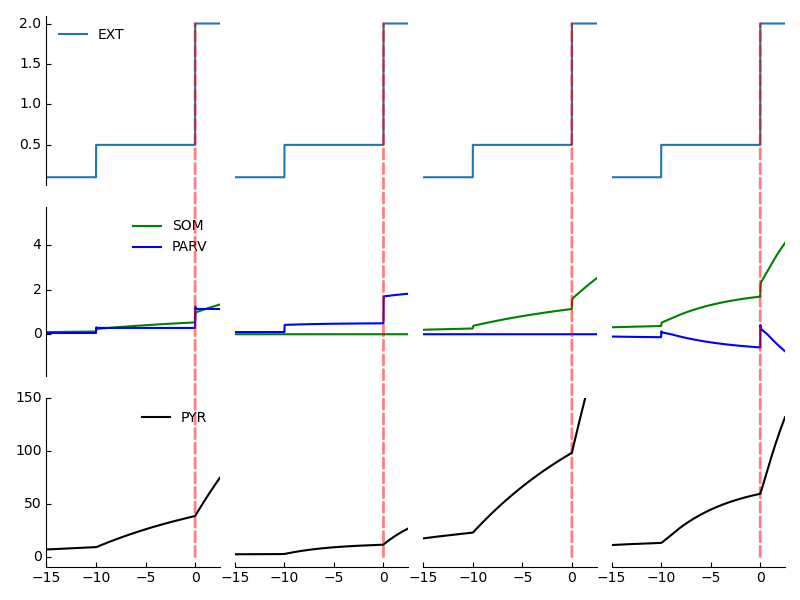

In [8]:
plot_target = False
t = res["t"]
ext = res["ext"]
fig = plt.figure(figsize=(8, 6))
ax_ext = add_axis(fig, 3,4,1, bottom=False)
ax_inh = add_axis(fig, 3,4,5, sharex=ax_ext, bottom=False)
ax = add_axis(fig, 3,4,9, sharex=ax_ext)

plext, = ax_ext.plot(t-25, ext)
ax_ext.legend([plext,], ['EXT'], frameon=False)
plsoms, = ax_inh.plot(t-25, res["soms_control"], '-g')
plparv, = ax_inh.plot(t-25, res["parv_control"], '-b')
plpyrs, = ax.plot(t-25, res["pyrs_control"], '-k')
if plot_target:
    plpyrs_target, = ax.plot(t-25, target_control, '--k')
ax_inh.legend([plsoms, plparv], ['SOM', 'PARV'], frameon=False)
ax.legend([plpyrs,], ['PYR',], frameon=False)
con = CP(xyA=(0, 0), xyB=(0, ext.max()),
         coordsA="data", coordsB="data", axesA=ax, axesB=ax_ext,
         arrowstyle="-", linestyle="dashed", linewidth=2, color="red", alpha=0.5)
ax.add_artist(con)
ax.set_xlim(-15, 2.5)

ax_ext_somsinh = add_axis(fig, 3,4,2, sharey=ax_ext, left=False, bottom=False)
ax_inh_somsinh = add_axis(fig, 3,4,6, sharex=ax_ext_somsinh, sharey=ax_inh, left=False, bottom=False)
ax_somsinh = add_axis(fig, 3,4,10, sharex=ax_ext_somsinh, sharey=ax, left=False)

plext, = ax_ext_somsinh.plot(t-25, ext)
plsoms, = ax_inh_somsinh.plot(t-25, res["soms_somsinh"], '-g')
plparv, = ax_inh_somsinh.plot(t-25, res["parv_somsinh"], '-b')
plpyrs, = ax_somsinh.plot(t-25, res["pyrs_somsinh"], '-k')
if plot_target:
    plpyrs_target, = ax_somsinh.plot(t-25, target_somsinh, '--k')
con = CP(xyA=(0, 0), xyB=(0, ext.max()),
         coordsA="data", coordsB="data", axesA=ax_somsinh, axesB=ax_ext_somsinh,
         arrowstyle="-", linestyle="dashed", linewidth=2, color="red", alpha=0.5)
ax_somsinh.add_artist(con)
ax_somsinh.set_xlim(-15, 2.5)

ax_ext_parvinh = add_axis(fig, 3,4,3, sharey=ax_ext, left=False, bottom=False)
ax_inh_parvinh = add_axis(fig, 3,4,7, sharex=ax_ext_parvinh, sharey=ax_inh, left=False, bottom=False)
ax_parvinh = add_axis(fig, 3,4,11, sharex=ax_ext_parvinh, sharey=ax, left=False)

plext, = ax_ext_parvinh.plot(t-25, ext)
plsoms, = ax_inh_parvinh.plot(t-25, res["soms_parvinh"], '-g')
plparv, = ax_inh_parvinh.plot(t-25, res["parv_parvinh"], '-b')
plpyrs, = ax_parvinh.plot(t-25, res["pyrs_parvinh"], '-k')
if plot_target:
    plpyrs_target, = ax_parvinh.plot(t-25, target_parvinh, '--k')
con = CP(xyA=(0, 0), xyB=(0, ext.max()),
         coordsA="data", coordsB="data", axesA=ax_parvinh, axesB=ax_ext_parvinh,
         arrowstyle="-", linestyle="dashed", linewidth=2, color="red", alpha=0.5)
ax_parvinh.add_artist(con)
ax_parvinh.set_xlim(-15, 2.5)

ax_ext_goal = add_axis(fig, 3,4,4, sharey=ax_ext, left=False, bottom=False)
ax_inh_goal = add_axis(fig, 3,4,8, sharex=ax_ext_goal, sharey=ax_inh, left=False, bottom=False)
ax_goal = add_axis(fig, 3,4,12, sharex=ax_ext_goal, sharey=ax, left=False)

plext, = ax_ext_goal.plot(t-25, ext)
plsoms, = ax_inh_goal.plot(t-25, res["soms_goal"], '-g')
plparv, = ax_inh_goal.plot(t-25, res["parv_goal"], '-b')
plpyrs, = ax_goal.plot(t-25, res["pyrs_goal"], '-k')
if plot_target:
    plpyrs_target, = ax_goal.plot(t-25, target_goal, '--k')
con = CP(xyA=(0, 0), xyB=(0, ext.max()),
         coordsA="data", coordsB="data", axesA=ax_goal, axesB=ax_ext_goal,
         arrowstyle="-", linestyle="dashed", linewidth=2, color="red", alpha=0.5)
ax_goal.add_artist(con)
ax_goal.set_xlim(-15, 2.5)
ax.set_ylim(-10, 150)
plt.tight_layout()

plt.savefig('scheme_v3.pdf')